# Structural Patterns

The creational patterns are guidelines suggested to compose objects in a way that allows to perform new functionalities. Those new functionalities would be harder to do without the new class/function created.

The structural patterns at the same time allows dealing with across entities relationships in an easier and managable way.

In simple words: **How to compose complex objects**

The seven structural patterns available are:
1. Adapter
2. Bridge
3. Composite
4. Decorador
5. Facade
6. Flyweight
7. Proxy

Each of those previous patterns are unique, and can be used in different situations and conditions.

# Adapter

**What is a adapter?**

An adapter is a design pattern that creates an object that allows that two incompatible interfaces can interact to each other seamlessly.

Instead of rewriting everything, you can create this new class that can wraps an `object 1` to be compatible with an `interface 1`.

**When should we use it?**

The adapter should be used when you have an specific piece of code that it does not match with the other logic of your code. For example, you have created a ML library to perform all as sklearn-like operations. However, this algorithm natively does not integrate anything like this. How to solve this? You can do this by using the adapter design pattern.

At the end, it allows to reduce some specific configurations for an unique object, it allows that the interface keeps the same for all objects you're creating.

**Analogy:**

You have a car, but you need to drive over some train rails. To do so, you need to create an additional machine which can allow the car to behave like a train an ride over the rails.

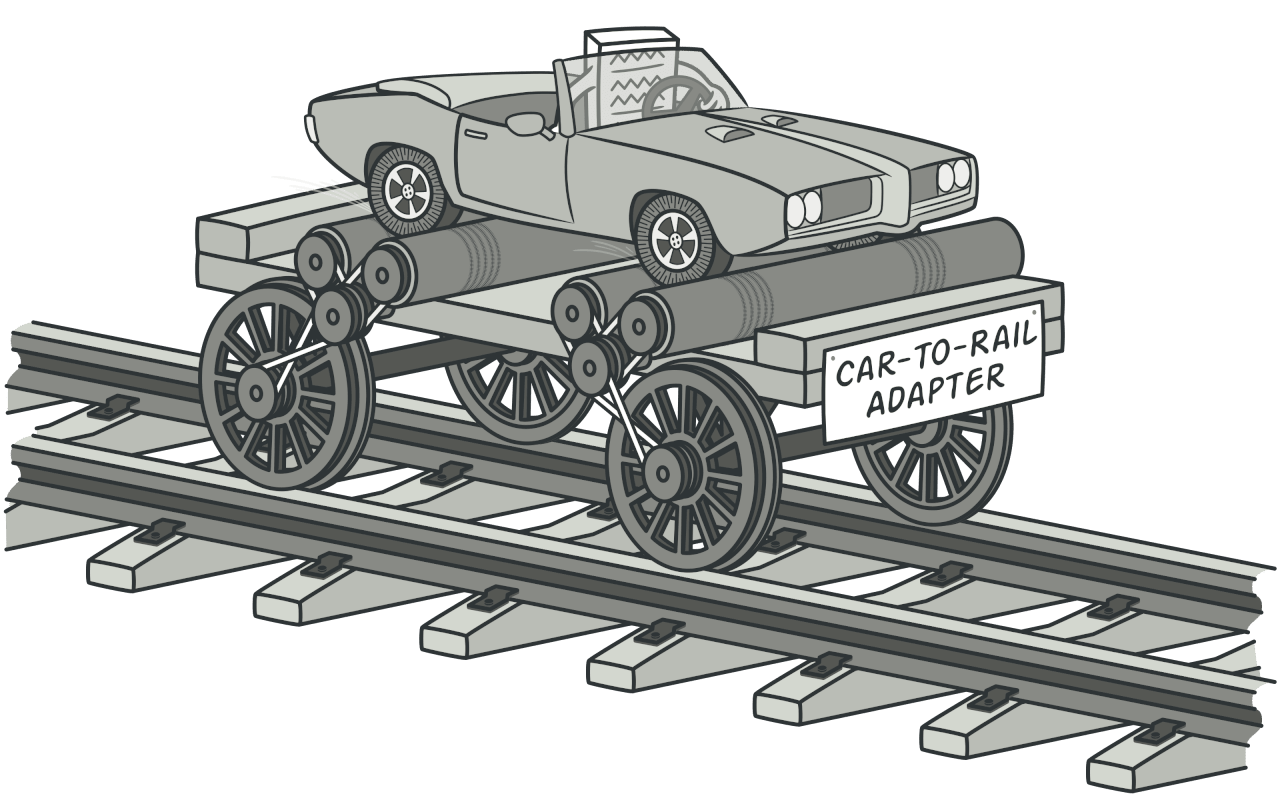

Reference: https://refactoring.guru/design-patterns/adapter

**Scenario**

We have developed a sklearn-like library to time-series forecasting. However, we want to implement the Theta model from statsmodels. How can we integrates seemlessly into our package the Theta model?

## Antipattern

What is the antipattern of this? That is a good question. 

1.  Let's going to create an abstract class to understand how the forecasting library would look-like.
2. Create the antipattern?

In [227]:
from abc import abstractmethod

import numpy as np
import pandas as pd

In [228]:
from statsmodels.tsa.forecasting.theta import ThetaModel

from statsforecast.models import AutoARIMA
from statsforecast import StatsForecast

In [229]:
from utilsforecast.data import generate_series
from utilsforecast.plotting import plot_series

In the core of our API, we have a fit and predict method. But what is the main capability of our API, it can make predictions over many time-series as much as we need based on the `unique_id` column.

In [230]:
class ForecastAPI:
    @abstractmethod
    def fit(
        self, df: pd.DataFrame, date_column: str, unique_col: str, target_col: str
    ) -> None:
        pass

    @abstractmethod
    def predict(self, horizon: int) -> pd.DataFrame:
        pass

Let's going to create an additional class which performs an AutoARIMA model training.

In [231]:
class ForecastARIMA(ForecastAPI):
    def __init__(self):
        self.fitted_model = None

    def fit(
        self, df: pd.DataFrame, date_column: str, unique_col: str, target_col: str
    ) -> None:
        self.fitted_model = StatsForecast(
            models=[AutoARIMA(season_length=12)], freq="D", n_jobs=1
        )
        self.fitted_model.fit(
            df=df, time_col=date_column, id_col=unique_col, target_col=target_col
        )

    def predict(self, horizon: int) -> pd.DataFrame:
        if self.fitted_model is None:
            raise ValueError("Model must be fitted before prediction.")
        return self.fitted_model.predict(horizon)

**What is the antipattern?**

Maybe someone may keep ThetaModel `AS IS` without any modification. Why? The statsmodels do not follow a sklearn-like style. They have their own API which is quite different.

Let's create the antipattern class

In [232]:
class ForecastTheta:
    def __init__(self, period: str = "M"):
        self.fitted_model = None
        if period == "M":
            self.period = 12

    def fit(self, y: np.array) -> None:
        self.fitted_model = ThetaModel(endog=y, period=self.period).fit()

    def predict(self, horizon: int) -> np.array:
        return self.fitted_model.forecast(horizon)

As you saw in the previous lines, the Theta model differs on how the training is being done. Let's going to create a simple time-series as example to showcase the antipattern.

In [233]:
random_data = generate_series(
    n_series=5,
    max_length=50,
    freq="D",
)

Let's see the antipattern how it breaks all of our previous code implementation

In [234]:
arima_model = ForecastARIMA()
arima_model.fit(
    df=random_data, date_column="ds", unique_col="unique_id", target_col="y"
)

In [235]:
y_pred_arima = arima_model.predict(horizon=10)

Here you can see the predictions from the ARIMA model

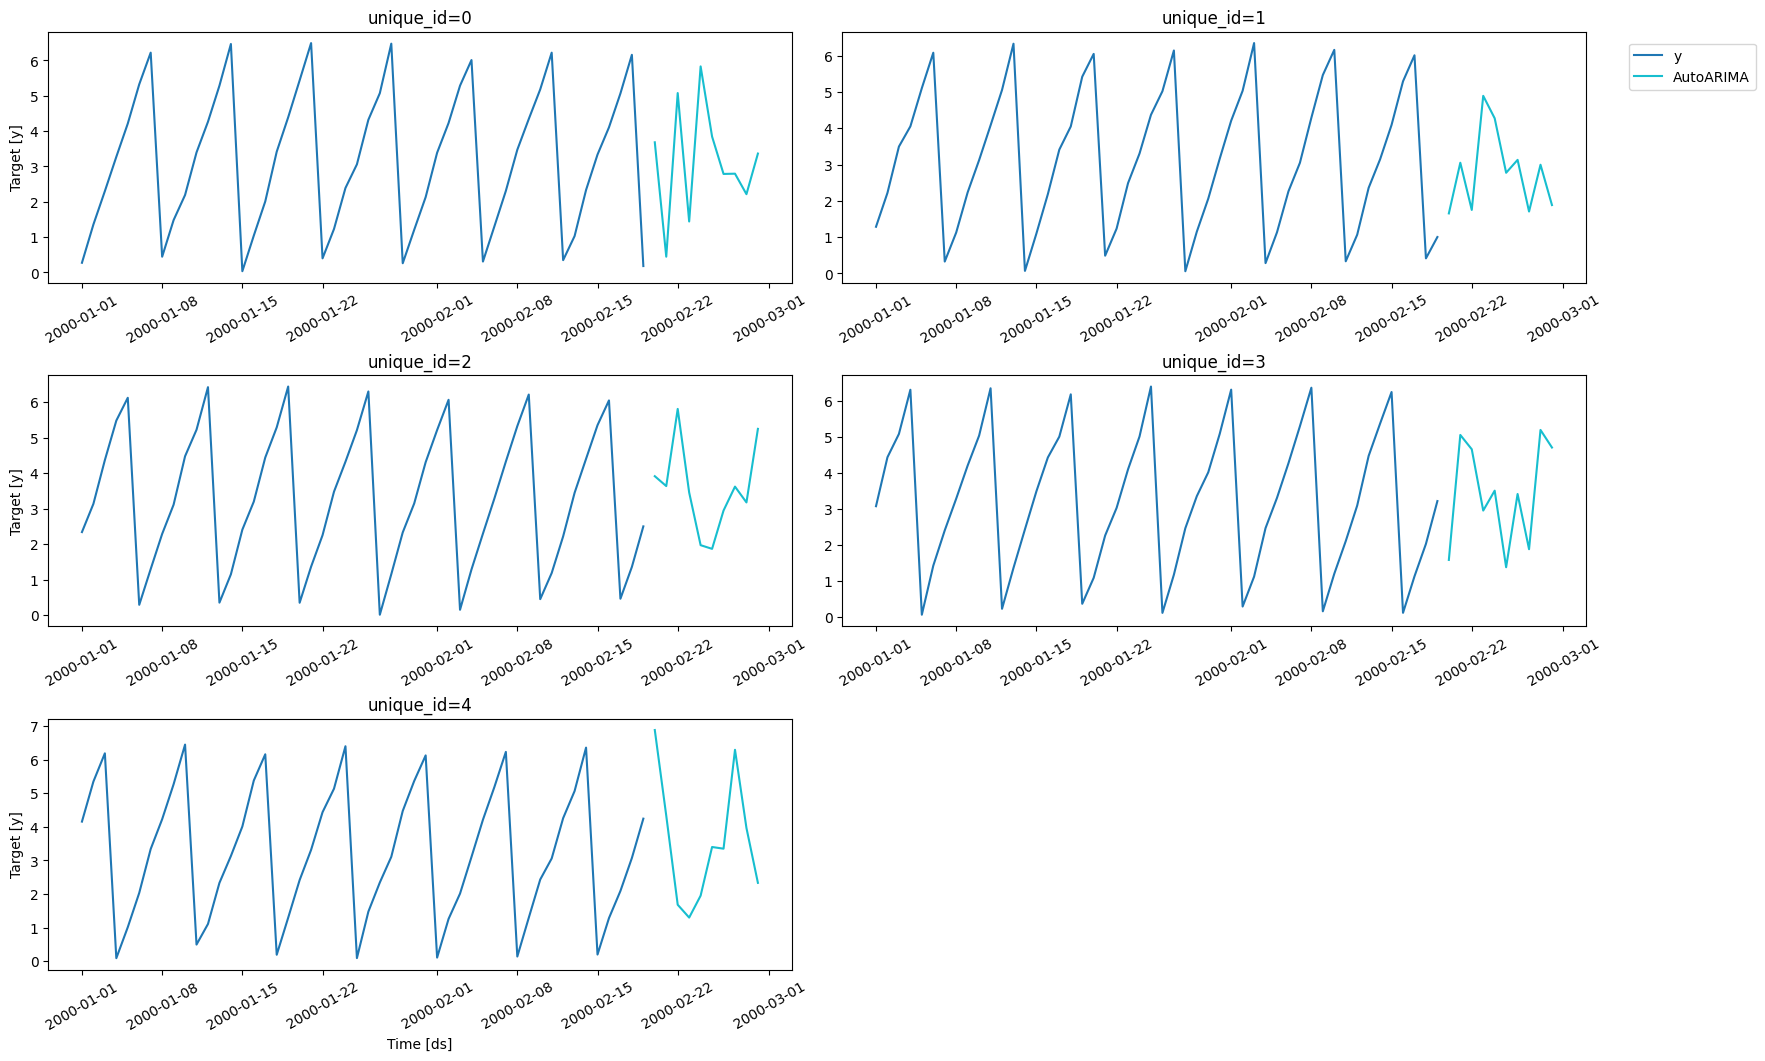

In [236]:
plot_series(random_data, y_pred_arima)

Now, let's going to create the Theta model and see how it breakes all the interface created for the automatic forecasting

In [237]:
theta_model = ForecastTheta()

In [238]:
theta_model.fit(y=random_data[random_data["unique_id"] == 0]["y"].values)

In [239]:
y_pred_theta = theta_model.predict(horizon=10)

In [240]:
y_pred_theta

50    3.321192
51    3.326014
52    3.330836
53    3.335658
54    3.340480
55    3.345302
56    3.350124
57    3.354946
58    3.359768
59    3.364590
Name: forecast, dtype: float64

Main issues with the previous implementation:

1. It can't deal with Pandas DataFrames natively
2. It can't deal with multiple time-series at the same time.
3. The output does not follow a common Pandas-like style. 

## Pattern

We can solve the antipattern by creating an adapter class which allows us to connect the ThetaModel from statsmodels into our `ForecastAPI`. Finally, we will get a simple API that can manage all previous issues

In [241]:
class AdapterTheta(ForecastAPI):
    def __init__(self, period: str = "M"):
        self.freq = period
        if period == "M":
            self.period = 12
        elif period == "D":
            self.period = 7
        self.date_column = None
        self.unique_col = None
        self.target_col = None
        self.start_forecast_date = None
        self.prediction_range = None
        self.fitted_models = {}

    def fit(
        self, df: pd.DataFrame, date_column: str, unique_col: str, target_col: str
    ) -> None:
        """
        This is the overall fitting method. Inside each unique time-series a Theta model will be fitted.
        """
        self.date_column = date_column
        self.unique_col = unique_col
        self.target_col = target_col
        # this will be used to save the minimum date
        self.start_forecast_date = df[date_column].max()
        for time_serie in df[unique_col].unique():
            df_time_serie = df[df[unique_col] == time_serie]
            fitted_model = self._fit_single_time_series(
                df_time_serie, date_column, target_col
            )
            self.fitted_models[time_serie] = fitted_model

    def _fit_single_time_series(
        self, df: pd.DataFrame, date_column: str, target_col: str
    ) -> None:
        """
        This method allows fitting a single time-series Theta Model
        """
        df = df.sort_values(by=date_column)
        y_values = df[target_col].values
        return ThetaModel(endog=y_values, period=self.period).fit()

    def _generate_time_periods(
        self, start_date: pd.Timestamp, periods: int
    ) -> pd.DatetimeIndex:
        """
        This method will generate the time periods for the prediction range
        """
        self.prediction_range = pd.date_range(
            start=start_date, periods=periods + 1, freq=self.freq, inclusive="neither"
        )

    def _predict_single_time_series(
        self, model: ThetaModel, horizon: int, unique_value: str
    ) -> pd.DataFrame:
        """
        This method allows making inference over a single time-series and return the data in the same format as the ForecastAPI
        """
        y_pred = model.forecast(horizon)
        data = {
            f"{self.unique_col}": [unique_value] * horizon,
            f"{self.date_column}": self.prediction_range,
            "ThetaModel": y_pred,
        }
        df = pd.DataFrame(data)
        return df

    def predict(self, horizon: int) -> pd.DataFrame:
        """
        This is the overall prediction method. Inside each unique time-series a Theta model will be used to make predictions.
        """
        for time_serie, model in self.fitted_models.items():
            self.theta_model = model
            self._generate_time_periods(
                start_date=self.start_forecast_date, periods=horizon
            )
            df_pred = self._predict_single_time_series(model, horizon, time_serie)
            if time_serie == list(self.fitted_models.keys())[0]:
                df_final = df_pred
            else:
                df_final = pd.concat([df_final, df_pred])
        return df_final

In [242]:
theta_model_adapter = AdapterTheta(period="D")

In [243]:
theta_model_adapter.fit(
    df=random_data, date_column="ds", unique_col="unique_id", target_col="y"
)

In [244]:
y_pred_adapter_theta = theta_model_adapter.predict(horizon=10)

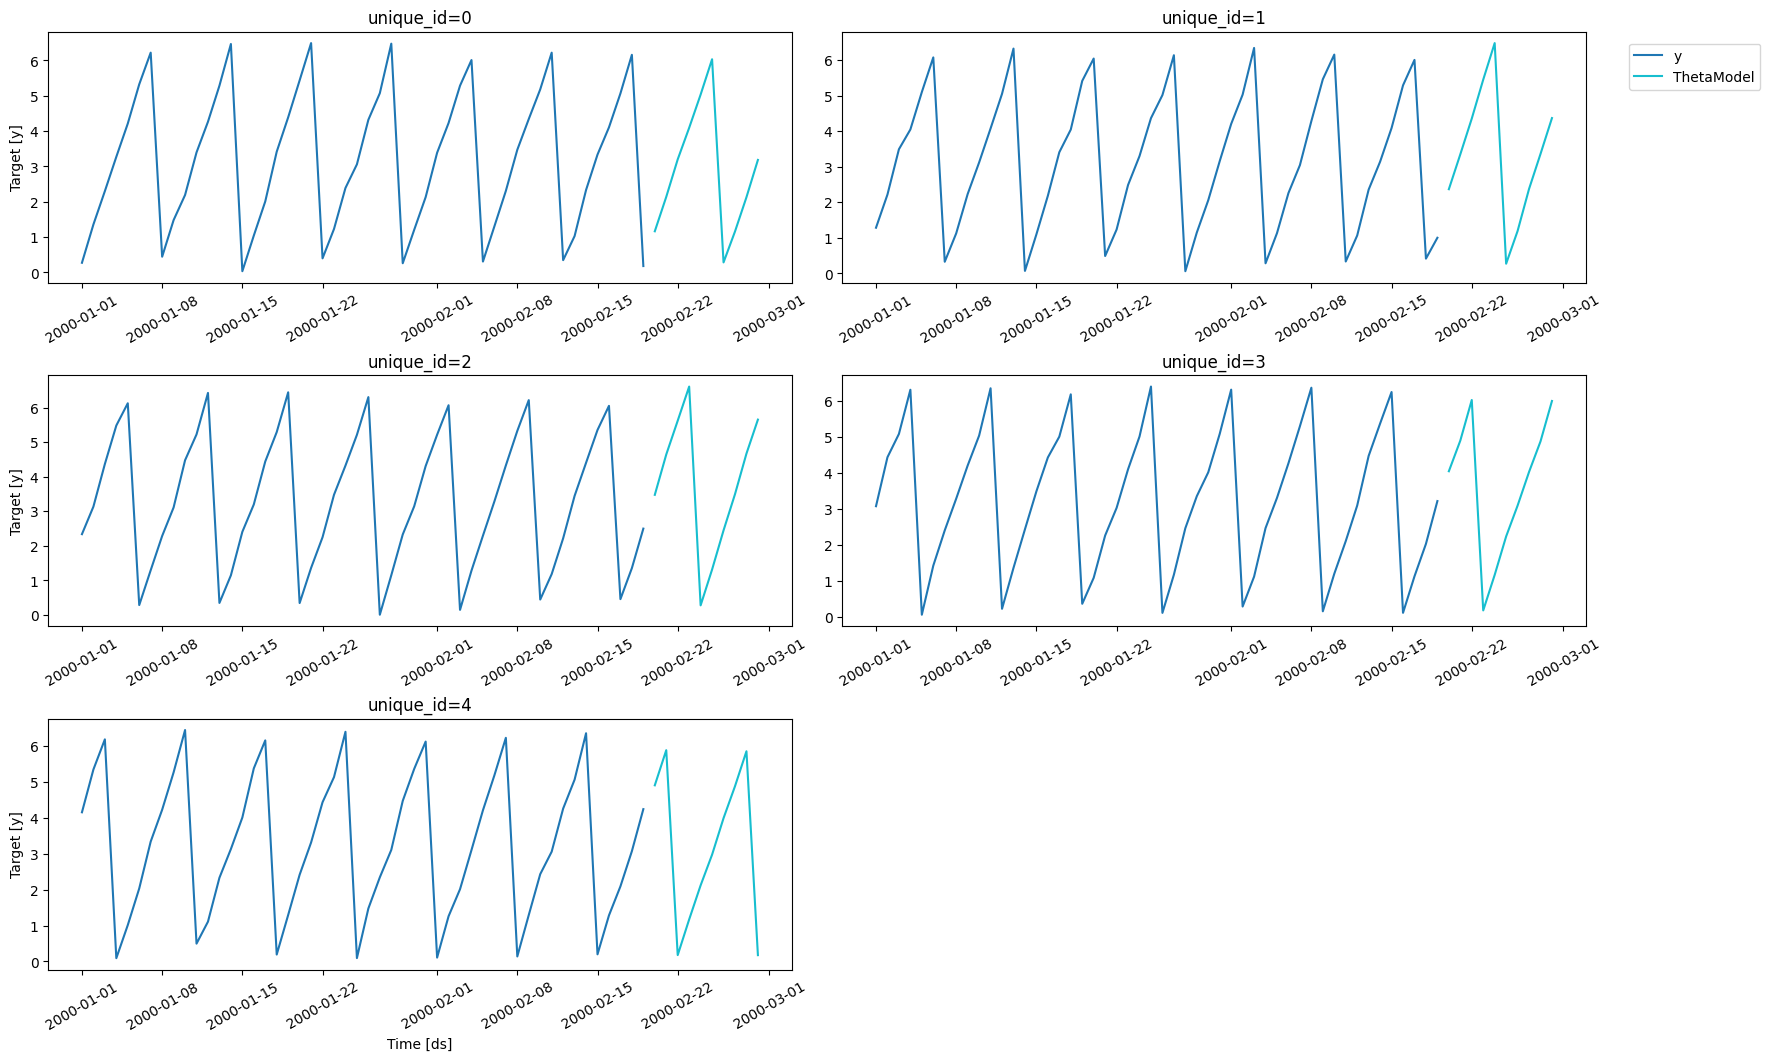

In [245]:
plot_series(random_data, y_pred_adapter_theta)

As you saw previously, the adapter allowed us to create a model in the same fashion as we did with the ARIMA-based model. This will reduce the overhead to implement new models while using the same interface.